# Run inference on image segmentation models with Torch

Discovery of multiple Image Segmentation models that was introduced in CV3 lecture.

#### **1. Semantic Segmentation**
- SegNet
- UNet
- DeepLab
- DeepLabV3

#### **2. Instance Segmentation**

**FCN based methods**

**Proposal-based methods**
- SDS
- Mask-RCNN (Two-stage segmentation)
- YolACT (One stage segmentation)


In [18]:
!pip install torchvision==0.19.1

## Helper functions

In [27]:
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]

  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  for i, img in enumerate(imgs):
    img = img.detach()
    img = F.to_pil_image(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


## DeepLab v3

In [106]:
from PIL import Image

parent = "/content/drive/MyDrive/masters/thesis/CV3 study/photos"
image_paths = os.listdir(parent)

pil_images = []
for img_path in image_paths:
  input_image = Image.open(str(Path(parent) / img_path))
  print(input_image.size)
  input_image = input_image.convert("RGB")
  if input_image.size[0] == 768:
    pil_images.append(input_image)

(1200, 1600)
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)
(1200, 1600)


In [137]:
from torchvision import transforms
import torch

def preprocess_input_images():
  preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ])

  input_tensors = [preprocess(img) for img in pil_images]
  print(input_tensors[0].shape)

  input_batch = torch.stack(input_tensors) # stack a list of tensor into a new dimension in a Tensor
  print(input_batch.shape)

  return input_batch


In [138]:
input_batch = preprocess_input_images()

torch.Size([3, 1024, 768])
torch.Size([5, 3, 1024, 768])


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

weights = DeepLabV3_ResNet101_Weights.DEFAULT

model = deeplabv3_resnet101(weights=weights, progress=False)
model = model.eval()

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(input_batch)

print(output)
# out: contains semantic masks
# aux: auxiliary loss values per-pixel (not useful in inference mode)

In [144]:
output['out'].shape # output for each sample

torch.Size([5, 21, 1024, 768])

In [196]:
def plot_side_by_side(segmentation_map, original):
  fig, axes = plt.subplots(1, 2, figsize=(5, 5))  # Create a figure with 2 subplots (side by side)

  # Plot the first image
  axes[0].imshow(segmentation_map)
  axes[0].axis('off')  # Hide axes

  # Plot the second image
  axes[1].imshow(original)
  axes[1].axis('off')  # Hide axes

  # Show the plot
  plt.tight_layout()  # Adjust layout
  plt.show()

def print_outputs(img_index):
  print(output['out'][img_index].shape)
  # unnormalized probabilities corresponding to the prediction of each class

  output_predictions = output['out'][img_index].argmax(0)
  # get the maximum prediction of each class
  print(output_predictions.shape)

  # create a color pallette, selecting a color for each class
  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

  # plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)

  plot_side_by_side(r, pil_images[img_index])


torch.Size([21, 1024, 768])
torch.Size([1024, 768])


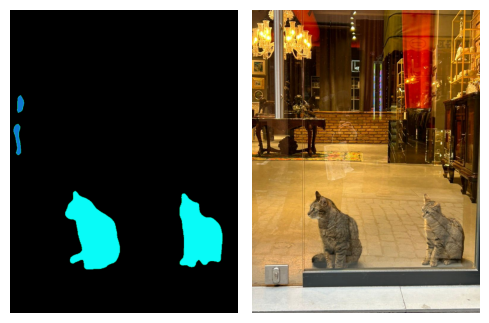

In [197]:
print_outputs(0)

torch.Size([21, 1024, 768])
torch.Size([1024, 768])


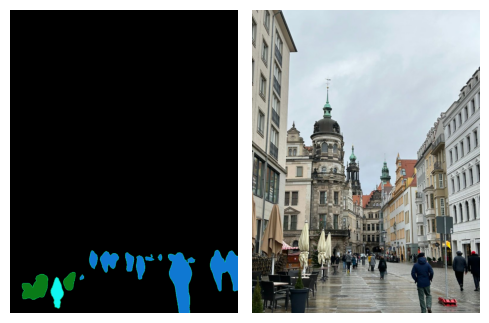

In [198]:
print_outputs(1)

torch.Size([21, 1024, 768])
torch.Size([1024, 768])


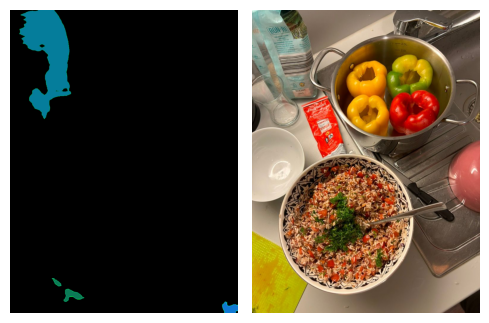

In [199]:
print_outputs(2)

torch.Size([21, 1024, 768])
torch.Size([1024, 768])


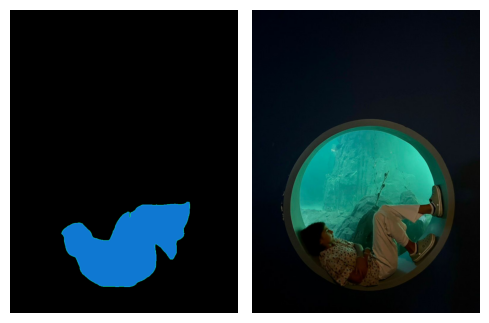

In [200]:
print_outputs(3)

torch.Size([21, 1024, 768])
torch.Size([1024, 768])


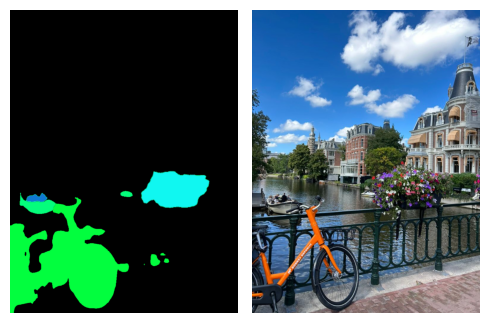

In [201]:
print_outputs(4)

## Mask RCNN

### Load images from Drive

In [154]:
import os
from torchvision.io import read_image
from pathlib import Path

parent = "/content/drive/MyDrive/masters/thesis/CV3 study/photos"
image_paths = os.listdir(parent)

img_tensor_list = []
for img_path in image_paths:
  img_tensor = read_image(str(Path(parent) / img_path))
  print(f"Shape: {img_tensor.size()} Name: {img_path}")
  if img_tensor.size()[1] == 1024:
    img_tensor_list.append(img_tensor)

Shape: torch.Size([3, 1600, 1200]) Name: WhatsApp Image 2024-10-02 at 15.04.56.jpeg
Shape: torch.Size([3, 1024, 768]) Name: WhatsApp Image 2024-10-02 at 15.05.27.jpeg
Shape: torch.Size([3, 1024, 768]) Name: WhatsApp Image 2024-10-02 at 15.06.12.jpeg
Shape: torch.Size([3, 1024, 768]) Name: WhatsApp Image 2024-10-02 at 15.06.22.jpeg
Shape: torch.Size([3, 1024, 768]) Name: WhatsApp Image 2024-10-02 at 15.06.38.jpeg
Shape: torch.Size([3, 1024, 768]) Name: WhatsApp Image 2024-10-02 at 15.07.15.jpeg
Shape: torch.Size([3, 1600, 1200]) Name: WhatsApp Image 2024-10-02 at 15.08.23.jpeg


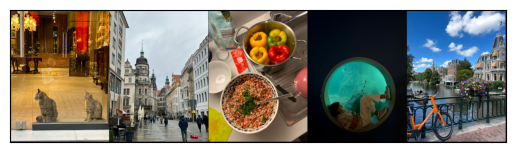

In [45]:
from torchvision.utils import make_grid

grid = make_grid(img_tensor_list)
grid.shape
show(grid)

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

transformed_input_batch = [transforms(i) for i in img_tensor_list]

maskrcnn_model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
maskrcnn_model = maskrcnn_model.eval()

maskrcnn_output = maskrcnn_model(transformed_input_batch)
print(maskrcnn_output)

In [60]:
print(len(maskrcnn_output)) # output for each image, each output is a list

5


Let's check the output for the first image

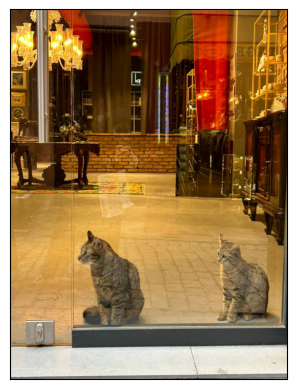

In [59]:
show(img_tensor_list[0])

In [157]:
def print_maskrcnn_output(output):
  print(f"Labels shape={output['labels'].shape}, dtype={output['labels'].dtype}"
      f", min={output['labels'].min()} max={output['labels'].max()}"
  )

  print(f"Detected labels: {[weights.meta['categories'][label] for label in output['labels']]}")

  print(f"Masks shape={output['masks'].shape}, dtype={output['masks'].dtype}"
        f", min={output['masks'].min()} max={output['masks'].max()}"
  )

  # each mask value shows the probability of likelihood each pixel belonging to the labels classes
  # shape: labels x w x h

  print(f"Scores shape={output['scores'].shape}, dtype={output['scores'].dtype}"
        f", min={output['scores'].min()} max={output['scores'].max()}"
  )

  print(f"Scores: {output['scores']}")

  print(f"Bounding boxes shape={output['boxes'].shape}, dtype={output['boxes'].dtype}"
        f", min={output['boxes'].min()} max={output['boxes'].max()}"
  ) # labels x 4 (coordinates)

In [168]:
from torchvision.utils import draw_segmentation_masks

def plot_maskrcnn_masks(output, image_tensor):
  proba_threshold = 0.8
  score_threshold = 0.75
  labels = output['labels'][output['scores'] > score_threshold]
  print(f"Labels: {[weights.meta['categories'][label] for label in labels]}")
  bool_masks = output['masks'][output['scores'] > score_threshold] > proba_threshold

  print(f"Masks shape: {bool_masks.shape} before: {output['masks'].shape}")

  bool_masks = bool_masks.squeeze(1)

  show(draw_segmentation_masks(image_tensor, bool_masks, alpha=0.9))

In [176]:
from torchvision.utils import draw_bounding_boxes

def plot_maskrcnn_bounding_boxes(output, image_tensor):
  score_threshold = .75
  result = draw_bounding_boxes(image_tensor,
                               output['boxes'][output['scores'] > score_threshold],
                               width=5)
  show(result)

In [174]:
print(maskrcnn_output[0].keys())
# boxes: bounding boxes, labels, scores, masks

print_maskrcnn_output(maskrcnn_output[0])

dict_keys(['boxes', 'labels', 'scores', 'masks'])
Labels shape=torch.Size([39]), dtype=torch.int64, min=1 max=88
Detected labels: ['cat', 'cat', 'backpack', 'person', 'teddy bear', 'motorcycle', 'motorcycle', 'backpack', 'person', 'bench', 'person', 'dining table', 'dining table', 'car', 'dog', 'dining table', 'vase', 'teddy bear', 'person', 'truck', 'backpack', 'pizza', 'bench', 'teddy bear', 'teddy bear', 'bench', 'chair', 'bird', 'bench', 'person', 'teddy bear', 'bicycle', 'bench', 'teddy bear', 'chair', 'dining table', 'truck', 'vase', 'book']
Masks shape=torch.Size([39, 1, 1024, 768]), dtype=torch.float32, min=0.0 max=0.9999908804893494
Scores shape=torch.Size([39]), dtype=torch.float32, min=0.050648435950279236 max=0.9981092214584351
Scores: tensor([0.9981, 0.9905, 0.6574, 0.5885, 0.5428, 0.5413, 0.3911, 0.3624, 0.3606,
        0.3537, 0.2635, 0.2133, 0.1897, 0.1752, 0.1656, 0.1582, 0.1578, 0.1412,
        0.1406, 0.1228, 0.1224, 0.1157, 0.1024, 0.0999, 0.0968, 0.0953, 0.0862,
  

Labels: ['cat', 'cat']
Masks shape: torch.Size([2, 1, 1024, 768]) before: torch.Size([39, 1, 1024, 768])


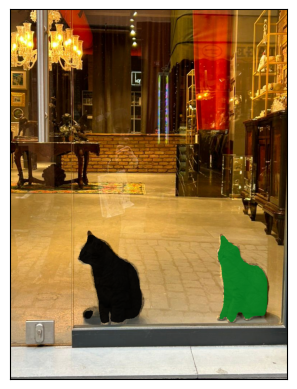

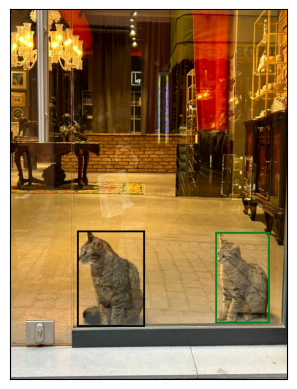

In [177]:
plot_maskrcnn_masks(maskrcnn_output[0], img_tensor_list[0])

plot_maskrcnn_bounding_boxes(maskrcnn_output[0], img_tensor_list[0])

Labels: ['person', 'person', 'person', 'person', 'chair', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'umbrella', 'person', 'person', 'umbrella', 'chair', 'person', 'umbrella']
Masks shape: torch.Size([21, 1, 1024, 768]) before: torch.Size([100, 1, 1024, 768])


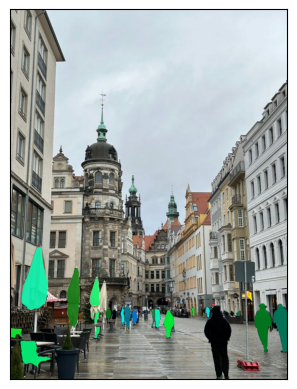

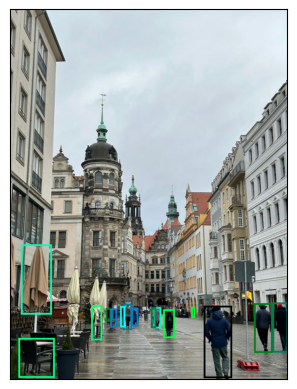

In [170]:
index = 1
plot_maskrcnn_masks(maskrcnn_output[index], img_tensor_list[index])
plot_maskrcnn_bounding_boxes(maskrcnn_output[index], img_tensor_list[index])

Labels: ['cup', 'bowl', 'bowl', 'donut', 'bottle', 'bowl', 'donut', 'carrot', 'carrot']
Masks shape: torch.Size([9, 1, 1024, 768]) before: torch.Size([91, 1, 1024, 768])


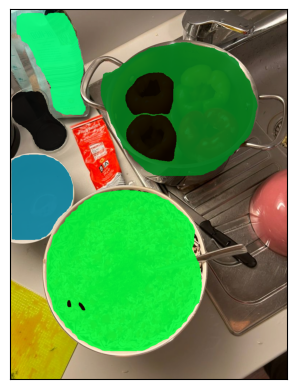

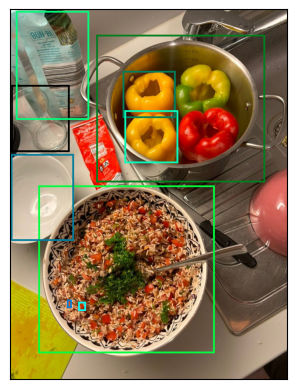

In [180]:
index = 2
plot_maskrcnn_masks(maskrcnn_output[index], img_tensor_list[index])

plot_maskrcnn_bounding_boxes(maskrcnn_output[index], img_tensor_list[index])

Labels: ['person', 'person']
Masks shape: torch.Size([2, 1, 1024, 768]) before: torch.Size([13, 1, 1024, 768])


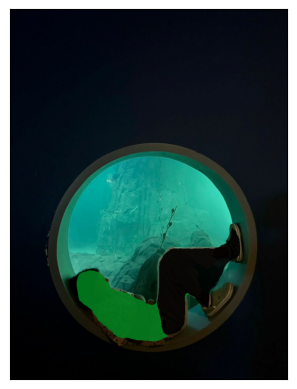

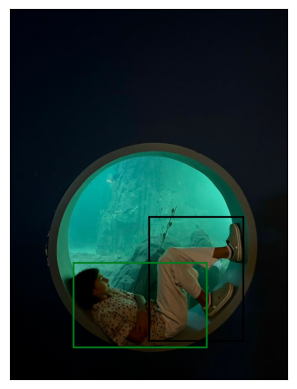

In [179]:
index = 3
plot_maskrcnn_masks(maskrcnn_output[index], img_tensor_list[index])

plot_maskrcnn_bounding_boxes(maskrcnn_output[index], img_tensor_list[index])

Labels: ['bicycle', 'boat', 'boat', 'person', 'person', 'person']
Masks shape: torch.Size([6, 1, 1024, 768]) before: torch.Size([50, 1, 1024, 768])


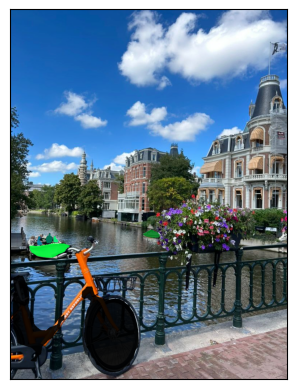

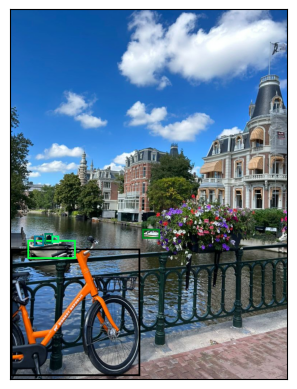

In [178]:
index = 4
plot_maskrcnn_masks(maskrcnn_output[index], img_tensor_list[index])

plot_maskrcnn_bounding_boxes(maskrcnn_output[index], img_tensor_list[index])